# Credit Card Fraud Detecting

Imbalance Dataset. Anonymized features

## Kaggle's Credit Card Fraud Dataset - RF

In this HW you'll apply a Logistic regression classifier to the problem of detecting credit card fraud.

The data is from: https://www.kaggle.com/mlg-ulb/creditcardfraud

Note that there are 28 anonymized variables in the data set and the charge amount. The variable "Class" is 0 for no fraud and 1 if the charge was fraudulent. 

The data set is in your data folder.

## Questions

1. Read in the data. How many observations do you have? What percentage of the data is fraudulent transactions? 
2. Create training (67% of the data) and test (33%) data sets. 
3. Fit a logistic regression classifier to the training data. 
4. Show the confusion matrix and accuracy for the training data. 
5. Show the confusion matrix and accuracy for the test data. Is there overfitting?
6. Compute various other metrics you have learnt to assess the performance of your classifier and say if you are satisfied with its performance. 
7. Go ahead and try other techniques you might know of to improve the performance of your classifier. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report,precision_recall_curve,roc_curve,recall_score, auc
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

### 1. Read in the data. How many observations do you have? What percentage of the data is fraudulent transactions?

In [2]:
df = pd.read_csv("DSTMAA_data/creditcard.csv")

In [3]:
df.shape

(284807, 31)

In [4]:
df.Class.mean()

0.001727485630620034

In [5]:
print('There are %.2f observations in this dataset.'%(len(df)))
print("The percentage of fraudulent transactions : {} %" .format(np.sum(df.Class==1) *100 /len(df.Class)))

There are 284807.00 observations in this dataset.
The percentage of fraudulent transactions : 0.1727485630620034 %


#### We have 284807 observations and 0.1727% of the data is fraudulent

In [6]:
# Normalize the data
df1 = df.copy()
var = df1.drop(['Class'], axis=1).columns.tolist()

In [7]:
from scipy import stats
norm_df = df1.apply(lambda x:stats.normaltest(x)[1])
print("There are %d features normally distributed." % ((norm_df<0.05).sum()))
print("Top 5 features with highest P value:")
norm_df.sort_values(ascending=False).head()

There are 31 features normally distributed.
Top 5 features with highest P value:


V13      2.419974e-126
Class     0.000000e+00
V14       0.000000e+00
V1        0.000000e+00
V2        0.000000e+00
dtype: float64

In [8]:
std_scaler = StandardScaler()
std_scaler.fit(df1[var].values) 
std_df = pd.DataFrame(std_scaler.transform(df1[var].values), columns = var)
std_df['Class'] = df['Class']

### 2. Create training (67% of the data) and test (33%) data sets.

In [9]:
X = std_df.drop(['Class'], axis=1)
y = std_df['Class']

In [10]:
# Evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

### 3. Fit a logistic regression classifier to the training data.  

In [11]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### 4. Show the confusion matrix and accuracy for the training data. 

In [12]:
# Predict class labels for the training set
pred_train = model.predict(X_train)
print(confusion_matrix(pred_train, y_train))
print('Accuracy =', accuracy_score(y_train, pred_train))

[[190463    121]
 [    27    209]]
Accuracy = 0.9992243999580757


### 5. Show the confusion matrix and accuracy for the test data. Is there overfitting?

In [13]:
# Predict class labels for the test set
pred_test = model.predict(X_test)
print(confusion_matrix(pred_test, y_test))
print('Accuracy =', accuracy_score(y_test, pred_test))

[[93810    65]
 [   15    97]]
Accuracy = 0.9991488184536159


Yes, the data is imbalanced and there is overfitting 

### 6. Compute various other metrics you have learnt to assess the performance of your classifier and say if you are satisfied with its performance. 

##### 6.1 Calculate AUC and graph ROC curve

In [14]:
probs = model.predict_proba(X_test)
print('AUC =', roc_auc_score(y_test, probs[:, 1]))

AUC = 0.9683328892441603


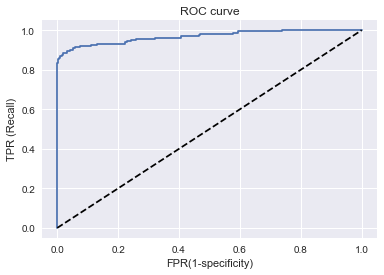

Area under curve (AUC):  0.9683328892441603


In [15]:
y_score = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

plt.title('ROC curve')
plt.xlabel('FPR(1-specificity)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print('Area under curve (AUC): ', auc(fpr,tpr))

In [16]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.87      0.60      0.71       162

    accuracy                           1.00     93987
   macro avg       0.93      0.80      0.85     93987
weighted avg       1.00      1.00      1.00     93987



The data is used for detecting credit card fraud, should focus on the recall value and the f1-score. Among the real positive values, we want to catch as much as possible. 

##### 6.2 Change Regulation Parameter

In [17]:
# Find the best C value
from sklearn.model_selection import validation_curve

In [18]:
C_param_range = [0.001,0.01,0.1,1,10,100]

AUC_table = pd.DataFrame(columns = ['C_parameter','roc_auc_score'])
AUC_table['C_parameter'] = C_param_range

j = 0
for i in C_param_range:
    
    # Apply logistic regression model to training data
    lr = LogisticRegression(penalty = 'l2', C = i,random_state = 0)
    lr.fit(X_train,y_train)
    
    probs = lr.predict_proba(X_test)
    
    # Predict using model
    #y_pred = lr.predict(X_test)
    
    # Saving accuracy score in table
    AUC_table.iloc[j,1] = roc_auc_score(y_test, probs[:,1])
    j += 1

In [19]:
AUC_table # 0.01 is the best 

,C_parameter,roc_auc_score
0,0.001,0.976685
1,0.010,0.974072
2,0.100,0.969533
3,1.000,0.968333
4,10.000,0.96819
5,100.000,0.968173


###### Apply the optimal c_parameter into the logistics regression

In [20]:
# Apply the optimal c_parameter into the logistics regression
model2 = LogisticRegression(C = 0.01 )   # regulation for overfitting change C = 0.01
model2.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
predicted2 = model2.predict(X_test)
probs2 = model2.predict_proba(X_test)
print(confusion_matrix(predicted2, y_test))
print('Accuracy =', accuracy_score(y_test, predicted2))
print('AUC =', roc_auc_score(y_test, probs2[:, 1]))
print(classification_report(y_test, predicted2))

[[93811    71]
 [   14    91]]
Accuracy = 0.9990956196069669
AUC = 0.9740717055984841
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.87      0.56      0.68       162

    accuracy                           1.00     93987
   macro avg       0.93      0.78      0.84     93987
weighted avg       1.00      1.00      1.00     93987



The recall and f1-score did not change by much, we are not satisfied about this performance

###### 6.3 Try using Lasso by changing penalty to L1 (default is L2)

In [22]:
Logit_Lasso = LogisticRegression(penalty='l1',solver='liblinear',C=0.1)
Logit_Lasso.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
# Predict class labels for the test set
pred_test_lasso = Logit_Lasso.predict(X_test)
print(confusion_matrix(pred_test_lasso, y_test))
print('Accuracy =', accuracy_score(y_test, pred_test_lasso))

[[93811    68]
 [   14    94]]
Accuracy = 0.9991275389149563


In [24]:
print(classification_report(y_test, pred_test_lasso))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.87      0.58      0.70       162

    accuracy                           1.00     93987
   macro avg       0.93      0.79      0.85     93987
weighted avg       1.00      1.00      1.00     93987



Again, the recall and f1-score did not change much, we are not satisfied with this performance

### 7. Go ahead and try other techniques you might know of to improve the performance of your classifier.

###### Oversampling

In [25]:
from imblearn.over_sampling import SMOTE

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size = 0.2, random_state = 0)

sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(X_train_2, y_train_2.ravel())

clf = LogisticRegression(C = 0.01)
model_res = clf.fit(X_train_res, y_train_res)

In [26]:
predicted_over = model_res.predict(X_test_2)
probs_over = model_res.predict_proba(X_test_2)
print('AUC =', roc_auc_score(y_test_2, probs_over[:, 1]))
print('Accuracy =', accuracy_score(y_test_2, predicted_over))
print(classification_report(predicted_over, y_test_2))
# recall drops to 0.06 

AUC = 0.9856540032223796
Accuracy = 0.9752993223552544
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     55466
           1       0.94      0.06      0.12      1496

    accuracy                           0.98     56962
   macro avg       0.96      0.53      0.55     56962
weighted avg       0.97      0.98      0.96     56962



###### Random Forest with oversampling 

In [27]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(random_state=0)

In [28]:
model_rf = rf.fit(X_train_2, y_train_2)

In [29]:
predicted_rf = model_rf.predict(X_test_2)
probs_rf = model_rf.predict_proba(X_test_2)
print('AUC =', roc_auc_score(y_test_2, probs_rf[:, 1]))
print('Accuracy =', accuracy_score(y_test_2, predicted_rf))
print(classification_report(predicted_rf, y_test_2))

AUC = 0.9440282634689666
Accuracy = 0.9994908886626171
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56876
           1       0.78      0.92      0.84        86

    accuracy                           1.00     56962
   macro avg       0.89      0.96      0.92     56962
weighted avg       1.00      1.00      1.00     56962



###### Random Forest with original data

In [30]:
model_rf2 = rf.fit(X_train, y_train)

In [31]:
predicted_rf2 = model_rf2.predict(X_test)
probs_rf2 = model_rf2.predict_proba(X_test)
print('AUC =', roc_auc_score(y_test, probs_rf2[:, 1]))
print('Accuracy =', accuracy_score(y_test, predicted_rf2))
print(classification_report(predicted_rf2, y_test))

AUC = 0.9427695045609603
Accuracy = 0.9994999308414994
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93852
           1       0.77      0.93      0.84       135

    accuracy                           1.00     93987
   macro avg       0.89      0.96      0.92     93987
weighted avg       1.00      1.00      1.00     93987

